In [68]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv('credit_card_default_analysis.csv', sep=',')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
df.shape

(30000, 25)

#### Размер кредитного лимита (LIMIT_BAL)

- для двух групп по признаку default проверить
    * гипотезу о равенстве медиан LIMIT_BAL (интервальная оценка)
    * гипотезу о равенстве распределений (непараметрический критерий проверки равенства средних)
- оценить практическую значимость результатов

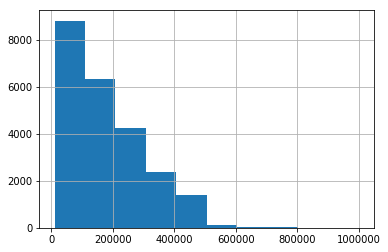

In [59]:
df[df.default == 0].LIMIT_BAL.hist()

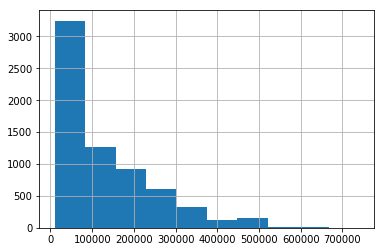

In [60]:
df[df.default == 1].LIMIT_BAL.hist()

Судя по графикам, распределения довольно сильно различаются.

In [17]:
df.default.value_counts()

0    23364
1     6636
Name: default, dtype: int64

Гипотеза: медианы кредитного лимита в группах равны. Альтернатива: медианы кредитного лимита в группах различаются.

Каждая из групп состоит из большого количества клиентов (более 50), поэтому доверительный интервал для медианы можно построить с помощью следующей функции (см. $\href{http://www.machinelearning.ru/wiki/index.php?title=Интервальная_оценка#.D0.9F.D1.80.D0.B8.D0.BC.D0.B5.D1.80_2._.D0.94.D0.BE.D0.B2.D0.B5.D1.80.D0.B8.D1.82.D0.B5.D0.BB.D1.8C.D0.BD.D1.8B.D0.B9_.D0.B8.D0.BD.D1.82.D0.B5.D1.80.D0.B2.D0.B0.D0.BB_.D0.B4.D0.BB.D1.8F_.D0.BC.D0.B5.D0.B4.D0.B8.D0.B0.D0.BD.D1.8B.}{ссылку}$).

In [38]:
def med_conf_int(X, alpha=0.05):
    N = len(X)
    ord_stats = np.sort(X)
    Z = stats.norm.ppf(1-alpha/2)
    k = int((N-Z*np.sqrt(N)-1)/2)
    return ord_stats[k-1], ord_stats[N-k]

In [42]:
data0 = df[df.default == 0].LIMIT_BAL.values
data1 = df[df.default == 1].LIMIT_BAL.values

In [43]:
med_conf_int(data0)

(150000, 150000)

In [44]:
med_conf_int(data1)

(80000, 90000)

Также можно построить доверительные интервалы на основе бутстрепа, результат получится тот же.

In [41]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [45]:
np.random.seed(0)

medians0 = map(np.median, get_bootstrap_samples(data0, 1000))
medians1 = map(np.median, get_bootstrap_samples(data1, 1000))

In [55]:
def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [56]:
stat_intervals(medians0)

array([150000., 150000.])

In [57]:
stat_intervals(medians1)

array([80000., 90000.])

Доверительные интервалы не пересекаются, это значит, гипотеза о равенстве медиан размера кредитного лимита отвергается на уровне значимости 0.05.

Для проверки гипотезы о равенстве средних можно использовать критерий Манна-Уитни, так как выборки независимые.

Нулевая гипотеза: распределения кредитного лимита в группах равны. Альтернатива: между распределениями есть сдвиг (в частности, средние значения кредитного лимита различаются).

In [58]:
stats.mannwhitneyu(data0,data1)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

Гипотеза о равенстве распределений отвергается на уровне значимости 0.05, так как p-value много меньше 5%.

Оценим размер эффекта.

In [66]:
print np.median(data0) - np.median(data1)
print np.mean(data0) - np.mean(data1)

60000.0
47990.069654772495


Такая сильная разница между медианами и средними имеет практическую значимость. Например, полученные данные помогают рассчитать максимальную долю невозвратов, которую банк может себе позволить, чтобы оставаться в точке безубыточности.

#### Пол (SEX)

- для вернувших и невернувших
    * построить доверительные интервалы для доли мужчин
    * проверить гипотезу о одинаковом гендерном составе групп

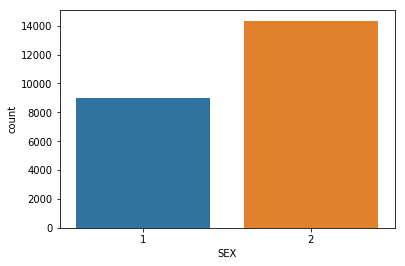

In [69]:
sns.countplot(df[df.default == 0].SEX)

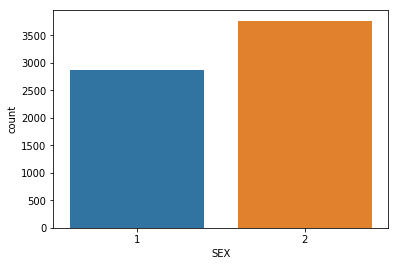

In [70]:
sns.countplot(df[df.default == 1].SEX)

Судя по графикам, доля мужчин среди невернувших клиентов выше.

Пол является бинарным признаком, поэтому уместно построить доверительные интервалы для доли.

Гипотеза: доля мужчин в обеих группах одинакова. Альтернатива: доли мужчин в группах различны.

In [72]:
from statsmodels.stats.proportion import proportion_confint

In [77]:
m0 = df[(df.default == 0) & (df.SEX == 1)].shape[0]
n0 = df[df.default == 0].shape[0]

m1 = df[(df.default == 1) & (df.SEX == 1)].shape[0]
n1 = df[df.default == 1].shape[0]

In [82]:
print proportion_confint(m0,n0)
print proportion_confint(m1,n1)

(0.37960806572767264, 0.3920919856333957)
(0.4210202357094044, 0.44486282637618935)


95%-е доверительные интервалы не пересекаются, это значит, что гипотеза о равенстве долей мужчин отвергается на уровне значимости 0.05.

Проверим ту же самую гипотезу, используя Z-критерий для доли для двух независимых выборок. 

In [92]:
def proportion_test(m0,n0,m1,n1):
    p1 = 1.*m0/n0
    p2 = 1.*m1/n1
    P = 1.*(m0 + m1)/(n0 + n1)
    Z = (p2-p1)/(np.sqrt(P*(1-P)*(1./n0+1./n1)))
    return 2*(1-stats.norm.cdf(Z))

In [93]:
proportion_test(m0,n0,m1,n1)

4.472866521609831e-12

p-value много меньше 5%, поэтому гипотеза об одинаковой доле мужчин отвергается на уровне значимости 0.05.

#### Образование (EDUCATION)

- проверить гипотезу "образование не влияет на то, вернет ли человек долг"
- наглядно представить разницу в ожидаемых и наблюдаемых значениях количества вернувших и не вернувных долг
- ответить на вопрос: наличие какого образования - лучший индикатор возврата / невозврата?

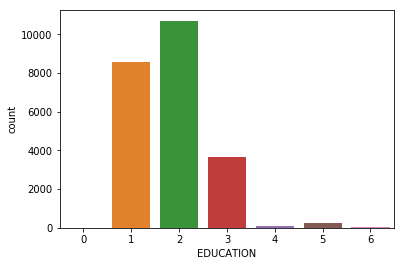

In [94]:
sns.countplot(df[df.default == 0].EDUCATION)

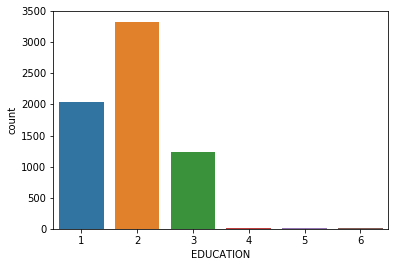

In [95]:
sns.countplot(df[df.default == 1].EDUCATION)

Как можно видеть из графиков, доли категорий 1 и 2 заметно отличаются в группах.

Мы имеем дело с двумя категориальными переменными, поэтому для проверки гипотезы о независимости образования и возврата кредита уместно использовать критерий хи-квадрат.

Гипотеза: признаки EDUCATION и default независимы. Альтернатива: признаки зависимы.

Условия применимости:
- выборки достаточно большие (более 40 наблюдений)
- не более 20% ячеек таблицы сопряженности имеют количество элементов меньше 5

In [115]:
obs0 = []
for i in range(7):
    obs0.append(df[df.default == 0].EDUCATION.value_counts()[i])

obs1 = [0]
for i in range(1,7):
    obs1.append(df[df.default == 1].EDUCATION.value_counts()[i])
    
print obs0
print obs1

[14, 8549, 10700, 3680, 116, 262, 43]
[0, 2036, 3330, 1237, 7, 18, 8]


Как можно видеть, критерий хи-квадрат применим.

In [117]:
stats.chi2_contingency([obs0,obs1])[1]

1.2332626245415605e-32

Достигаемый уровень значимости много меньше 5%, поэтому нулевая гипотеза отвергается на уровне значимости 0.05.

Теперь составим таблицу разностей между количеством вернувших и не вернувших кредит по каждой категории образования. Для вычисления разностей масштабируем значения в исходных массивах - поделим значение каждой ячейки на количество элементов в выборке и умножим на 10000.

In [130]:
diff = []

for i in range(7):
    diff.append(int(10000.*obs0[i]/n0-10000.*obs1[i]/n1))

print diff

[5, 590, -438, -289, 39, 85, 6]


Лучший индикатор возврата - наличие степени магистра, невозврата - наличие степени бакалавра.

#### Семейное положение (MARRIAGE)

Проверить связь семейного статуса с индикатором дефолта: предложить меру измерения взаимосвязи и посчитать ее значение.

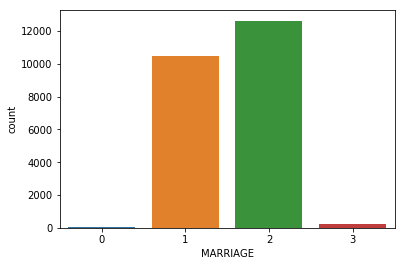

In [131]:
sns.countplot(df[df.default == 0].MARRIAGE)

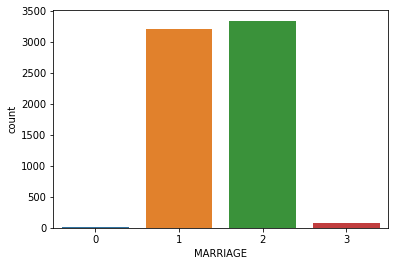

In [132]:
sns.countplot(df[df.default == 1].MARRIAGE)

Доли категорий 1 и 2, судя по графикам, отличаются в группах.

Мы имеем дело с двумя категориальными переменными, сила взаимосвязи между которыми измеряется с помощью коэффициента V Крамера.

In [150]:
def cramers_V(X1,X2):
    chi2 = stats.chi2_contingency([X1,X2])[0]
    n = np.sum(X1)+np.sum(X2)
    return np.sqrt(chi2/n)

In [151]:
obs0 = []
obs1 = []

for i in range(4):
    obs0.append(df[df.default == 0].MARRIAGE.value_counts()[i])
    obs1.append(df[df.default == 1].MARRIAGE.value_counts()[i])    
    
print obs0
print obs1

[49, 10453, 12623, 239]
[5, 3206, 3341, 84]


In [152]:
cramers_V(obs0,obs1)

0.034478203662766466

Коэффициент Крамера принимает значения в интервале между 0 и 1. Полученное значение говорит о слабой взаимосвязи между признаками. Тем не менее, гипотеза о независимости признаков отвергается на уровне значимости 0.05, что видно из низкого p-value (условия применимости - аналогично случаю с EDUCATION - выполняются).

In [154]:
stats.chi2_contingency([obs0,obs1])[1]

8.825862457577375e-08

Вывод: переменные зависимы, но взаимосвязь между ними очень слабая.

#### Возраст (AGE)

- для обеих групп проверить гипотезы:
    * о равенстве медиан возрастов
    * о равенстве распределений (непараметрический критерий проверки равенства средних)
- оценить результаты с практической точки зрения

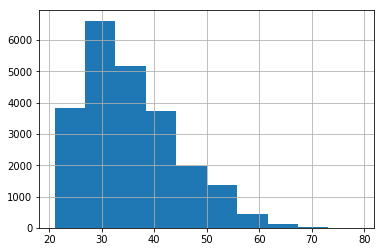

In [155]:
df[df.default == 0].AGE.hist()

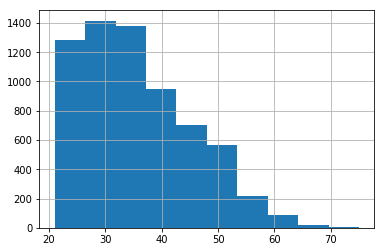

In [156]:
df[df.default == 1].AGE.hist()

На первый взгляд распределения возрастов в группах похожи.

Гипотеза: медианы возрастов в группах равны. Альтернатива: медианы возрастов в группах различаются.

Каждая из групп состоит из большого количества клиентов (более 50), поэтому доверительный интервал для медианы можно построить с помощью следующей функции med_conf_int (как это делалось выше).

In [159]:
data0 = df[df.default == 0].AGE.values
data1 = df[df.default == 1].AGE.values

print med_conf_int(data0)
print med_conf_int(data1)

(34, 34)
(34, 35)


Также можно построить доверительные интервалы на основе бутстрепа, результат получится тот же.

In [160]:
np.random.seed(0)

medians0 = map(np.median, get_bootstrap_samples(data0, 1000))
medians1 = map(np.median, get_bootstrap_samples(data1, 1000))

print stat_intervals(medians0)
print stat_intervals(medians1)

[34. 34.]
[34. 35.]


Доверительные интервалы пересекаются (один из них содержится в другом), это значит, гипотеза о равенстве медиан возрастов не отвергается на уровне значимости 0.05.

Для проверки гипотезы о равенстве средних можно использовать критерий Манна-Уитни, так как выборки независимые.

Нулевая гипотеза: распределения возрастов в группах равны. Альтернатива: между распределениями есть сдвиг (в частности, средние значения возрастов различаются).

In [161]:
stats.mannwhitneyu(data0,data1)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

Гипотеза о равенстве распределений не отвергается на уровне значимости 0.05, так как p-value больше 5%.

Оценим размер эффекта.

In [162]:
print np.median(data0) - np.median(data1)
print np.mean(data0) - np.mean(data1)

0.0
-0.308472517494188


Практическая значимость полученного результата: возраст не является индикатором возврата кредита.